In [1]:
import random

import torch
import numpy as np
from bindsnet.network import Network
from bindsnet.network.nodes import Input
from bindsnet.learning.learning import MSTDPET, PostPre, NoOp
from bindsnet.network.topology import Connection
from bindsnet.network.monitors import Monitor

from libs.learning import PostPreInh, MSTDPET_SEASONAL, MSTDP_SEASONAL, RSTDP_SEASONAL, AbstractSeasonalLearning
from libs.second_appr_simp_t2 import CorticalColumn, LayerConnection, ComplexStructure, load, LAYER_23, LAYER_4
from libs.connections import ConnectionWithConvergence, RandomConnection, get_output_size_maxpool1d

In [2]:
seed = random.randint(0,9999999)
print(seed)

4871644


In [3]:
# seed = 1400
random.seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed_all(seed)
torch.manual_seed(seed)

# Prepare Inputs

In [4]:
input_size_c1 = 200
input_size_c2 = 200
each_session = 40
session_number = 500
# layer23_involve_from = 500
gap_time = 20

time = session_number * each_session
spike_train_c1 = torch.zeros(time, input_size_c1).bool()
spike_train_c2 = torch.zeros(time, input_size_c2).bool()
timestep_class = torch.zeros(time).bool()

session_class = torch.rand(session_number) < 0.5
# session_class = torch.tensor(([True, False] * int((session_number + 1) / 2))[:session_number])

active_fire_rate = 0.2


pattern_size = int(input_size_c1/2)
for idx, cls in enumerate(session_class):
    passive_noise = torch.rand(each_session, input_size_c1) < 0.01 + (random.random() * 0.01 - 0.005)
    spike_train_c1[idx * each_session: (idx + 1) * each_session, :] = passive_noise
    if cls:
        pattern_1 = torch.rand(each_session, pattern_size) < active_fire_rate
        pattern_1[each_session - gap_time:, :] = 0
        spike_train_c1[idx * each_session: (idx + 1) * each_session, :int(input_size_c1/2)] |= pattern_1
    else:
        pattern_2 = torch.rand(each_session, pattern_size) < active_fire_rate
        pattern_2[each_session - gap_time:, :] = 0
        spike_train_c1[idx * each_session: (idx + 1) * each_session, int(input_size_c1/2):] |= pattern_2
    
    timestep_class[idx * each_session: (idx + 1) * each_session] = cls
    
pattern_size = int(input_size_c2/2)
for idx, cls in enumerate(session_class):
    passive_noise = torch.rand(each_session, input_size_c2) < 0.01 + (random.random() * 0.01 - 0.005)
    spike_train_c2[idx * each_session: (idx + 1) * each_session, :] = passive_noise
    if cls:
        pattern_1 = torch.rand(each_session, pattern_size) < active_fire_rate
        pattern_1[each_session - gap_time:, :] = 0
        spike_train_c2[idx * each_session: (idx + 1) * each_session, :int(input_size_c2/2)] |= pattern_1
    else:
        pattern_2 = torch.rand(each_session, pattern_size) < active_fire_rate
        pattern_2[each_session - gap_time:, :] = 0
        spike_train_c2[idx * each_session: (idx + 1) * each_session, int(input_size_c2/2):] |= pattern_2
    
    timestep_class[idx * each_session: (idx + 1) * each_session] = cls

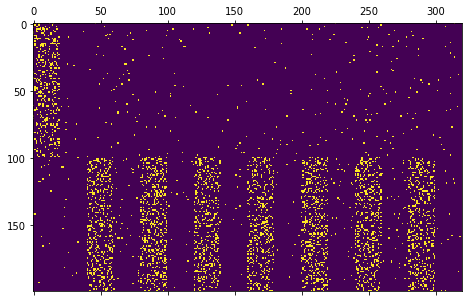

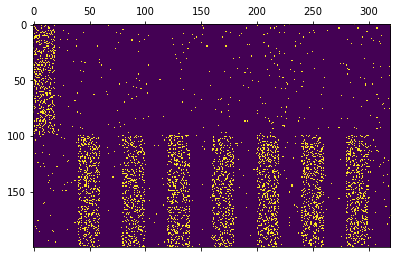

In [5]:
import matplotlib.pyplot as plt

plt.matshow(spike_train_c1.T[:, :8 * each_session])
plt.matshow(spike_train_c2.T[:, :8 * each_session])

# Load Models

In [6]:
c1_complex = load('models/c1.pt')
c2_complex = load('models/c2.pt')

In [7]:
c1 = c1_complex.submodules[0]
c2 = c2_complex.submodules[0]

In [8]:
c1.disable_learning()
c2.disable_learning()

# Create Model

In [9]:
connection_args = { # Between Layer
    'kernel_size': 5,
    'stride': 3,
    'weight': 16,
}
layer_args_l23 = {
    'exc_size': get_output_size_maxpool1d(100, 5, 3),
    'inh_con_args': { # Inside Layer
        'wmin': -1.5,
        'wmax': 0,
        'update_rule': NoOp,
        'probability': 1.0,
    },
    'exc_args': {
        'thresh': -52.0,
        'tc_trace': 15,
        'traces': True,
        'tc_decay': 10,
        'refrac': 3,
    }
}
layer_args_l4 = {
    'exc_size': 100,
    'inh_con_args': { # Inside Layer
        'wmin': -0.5,
        'wmax': 0,
        'update_rule': NoOp,
        'probability': 0.30,
    },
    'exc_args': {
        'thresh': -52.0,
        'tc_trace': 15,
        'traces': True,
        'tc_decay': 10,
        'refrac': 3,
    }
}
input_to_cc_con_args = {
    'wmin': 0.,
    'wmax': 0.8,
    'nu': [0.03, 0.01],
#     'update_rule': PostPre,
    'probability': 0.40,
    
    'update_rule': MSTDPET_SEASONAL,
    'tc_plus': 10,
    'tc_minus': 10, 
    'tc_e_trace': 10,
}
connection_type = RandomConnection

In [10]:
c3 = CorticalColumn(connection_args, layer_args_l23, layer_args_l4, name="c3", monitor=LAYER_23|LAYER_4)

In [11]:
print(c3.get_input_pops())
print(c3.get_output_pops())

[('c3_l4__exc1', LIFNodes()), ('c3_l4__exc2', LIFNodes())]
[('c3_l23__exc1', LIFNodes()), ('c3_l23__exc2', LIFNodes())]


In [12]:
c1_c3_connection = LayerConnection(c1_complex, c3, connection_type, input_to_cc_con_args)
c2_c3_connection = LayerConnection(c2_complex, c3, connection_type, input_to_cc_con_args)

In [13]:
c1_c3_connection.connections

[('c1_l23__exc1',
  'c3_l4__exc1',
  RandomConnection(
    (source): LIFNodes()
    (target): LIFNodes()
  )),
 ('c1_l23__exc1',
  'c3_l4__exc2',
  RandomConnection(
    (source): LIFNodes()
    (target): LIFNodes()
  )),
 ('c1_l23__exc2',
  'c3_l4__exc1',
  RandomConnection(
    (source): LIFNodes()
    (target): LIFNodes()
  )),
 ('c1_l23__exc2',
  'c3_l4__exc2',
  RandomConnection(
    (source): LIFNodes()
    (target): LIFNodes()
  ))]

In [14]:
model = ComplexStructure()
model.add_submodule(c1_complex)
model.add_submodule(c2_complex)
model.add_submodule(c3)
model.add_submodule(c1_c3_connection)
model.add_submodule(c2_c3_connection)
model.add_outpops(c3.get_output_pops())

# Add to Network

In [15]:
network = Network(dt=1.0)
model.add_to_network(network)

In [16]:
bl_monitors = []
bl_monitors_name = []
for a, b, con in c1_c3_connection.connections + c2_c3_connection.connections:
    tmp = Monitor(obj=con, state_vars=['converge'])
    network.add_monitor(monitor=tmp, name=f"{a}_{b}_connection_monitor")
    bl_monitors.append(tmp)
    bl_monitors_name.append((a, b))
    

# Run Network

In [17]:
from tqdm import trange

rewards = []
changes = []
activities = []
# inputs = {'input_c1' : spike_train}
for part in trange(session_number, unit="parts"):
# for part in trange(1, unit="parts"):

#     if part == layer23_involve_from:
#         c3.l4.disable_learning()
#         input_to_c1_connection.disable_learning()
        
#         c3.l23.enable_learning()
#         c3.l4_l23.enable_learning()
        
        
    inp = {
        'input_c1': spike_train_c1[part*each_session:part*each_session+each_session, :],
        'input_c2': spike_train_c2[part*each_session:part*each_session+each_session, :],
    }
    network.run(inputs=inp, time=each_session)
    
    avg_sessions = 10
    in_use_sessions = min(part + 1, avg_sessions)
    exc1_avg = c3.l23.monitors[0][1].get('s')[-each_session * in_use_sessions:,0,:].sum() / in_use_sessions
    exc2_avg = c3.l23.monitors[1][1].get('s')[-each_session * in_use_sessions:,0,:].sum() / in_use_sessions
    
    exc1_act = c3.l23.monitors[0][1].get('s')[-each_session:,0,:].sum()# - exc1_avg
    exc2_act = c3.l23.monitors[1][1].get('s')[-each_session:,0,:].sum()# - exc2_avg
    
    activities.append((exc1_act, exc2_act))
    
    pattern = session_class[part]
    gap = abs(exc2_act - exc1_act) / layer_args_l23['exc_size']  #  In Range 0-1
    gap_check = abs(exc2_act - exc1_act) / layer_args_l23['exc_size'] > 0.3
    
    exc1_wins = exc1_act > exc2_act
    
    if pattern == exc1_wins and gap_check:
        reward = 1.0 + gap
    elif pattern == exc1_wins:
        reward = -0.5 + gap
    else:
        reward = -1 - gap
        
    rewards.append(reward)
    
    for conn in c1_c3_connection.connections + c2_c3_connection.connections:
        if isinstance(conn[2].update_rule, AbstractSeasonalLearning):
            change = conn[2].update_rule.trigger(reward)
            changes.append(change)
    

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [02:09<00:00,  3.87parts/s]


In [18]:
rewards

[tensor(-1.7812),
 tensor(-2.9688),
 tensor(2.5625),
 tensor(3.8438),
 tensor(4.5000),
 tensor(4.5938),
 tensor(4.5625),
 tensor(4.9688),
 tensor(-3.5000),
 tensor(-3.0312),
 tensor(2.6562),
 tensor(4.3750),
 tensor(2.1875),
 tensor(3.8125),
 tensor(4.7500),
 tensor(4.2500),
 tensor(4.4062),
 tensor(3.0625),
 tensor(4.4062),
 tensor(4.),
 tensor(3.8750),
 tensor(4.0938),
 tensor(3.4375),
 tensor(3.8750),
 tensor(4.),
 tensor(4.1562),
 tensor(4.1875),
 tensor(3.9375),
 tensor(3.5000),
 tensor(4.5938),
 tensor(3.2500),
 tensor(4.3125),
 tensor(4.0312),
 tensor(4.2812),
 tensor(3.7500),
 tensor(4.4375),
 tensor(4.1875),
 tensor(3.9688),
 tensor(3.7500),
 tensor(3.6562),
 tensor(4.2500),
 tensor(4.0312),
 tensor(4.2188),
 tensor(3.5938),
 tensor(4.0938),
 tensor(3.9375),
 tensor(4.),
 tensor(3.7812),
 tensor(3.9062),
 tensor(4.),
 tensor(4.3125),
 tensor(4.4688),
 tensor(4.0312),
 tensor(4.),
 tensor(4.0625),
 tensor(4.2500),
 tensor(4.1875),
 tensor(4.1562),
 tensor(3.7188),
 tensor(4.718

# Analysis

In [19]:
time_show = time

In [20]:
spikes = {
    "C1 Output | 1": c1.l23.monitors[0][1].get('s')[-time_show:,0,:].T, 
    "C1 Output | 2": c1.l23.monitors[1][1].get('s')[-time_show:,0,:].T, 
    
    "C2 Output | 1": c2.l23.monitors[0][1].get('s')[-time_show:,0,:].T, 
    "C2 Output | 2": c2.l23.monitors[1][1].get('s')[-time_show:,0,:].T, 
    
    "L4 | 1": c3.l4.monitors[0][1].get('s')[-time_show:,0,:].T, 
    "L4 | 2": c3.l4.monitors[1][1].get('s')[-time_show:,0,:].T, 
    
    "L23 | 1": c3.l23.monitors[0][1].get('s')[-time_show:,0,:].T, 
    "L23 | 2": c3.l23.monitors[1][1].get('s')[-time_show:,0,:].T,
}

## Convergence

('c1_l23__exc1', 'c3_l4__exc1')
('c1_l23__exc1', 'c3_l4__exc2')
('c1_l23__exc2', 'c3_l4__exc1')
('c1_l23__exc2', 'c3_l4__exc2')
('c2_l23__exc1', 'c3_l4__exc1')
('c2_l23__exc1', 'c3_l4__exc2')
('c2_l23__exc2', 'c3_l4__exc1')
('c2_l23__exc2', 'c3_l4__exc2')


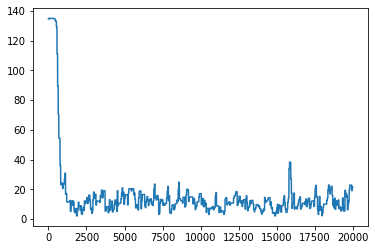

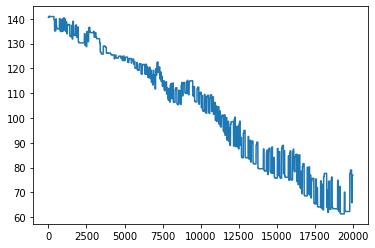

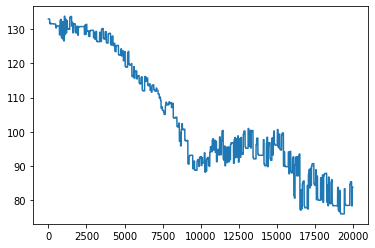

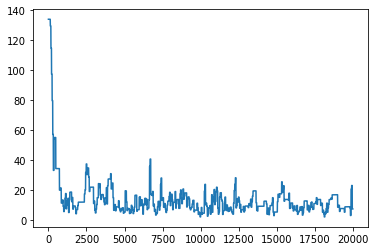

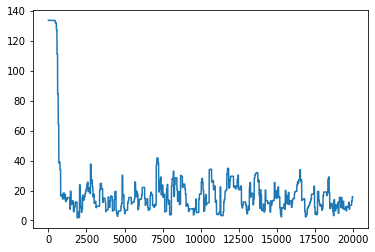

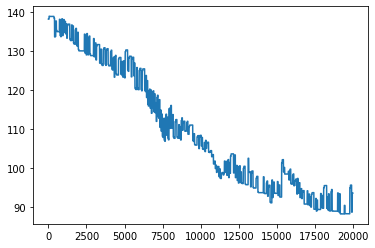

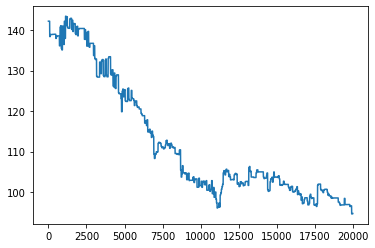

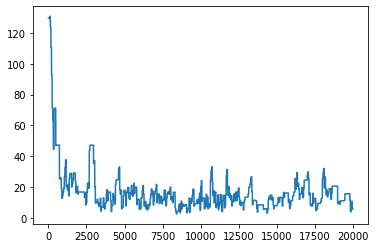

In [21]:
for name, m in zip(bl_monitors_name, bl_monitors):
    print(name)
    plt.figure()
    plt.plot(m.get('converge'))

## Confusion

### Layer 4

In [22]:
print(f"L4 -- Excitatory 1 -- Pattern 1     :    {spikes['L4 | 1'][:, -1500:][:, timestep_class[-1500:]].sum() / session_class[-50:].sum()}")
print(f"L4 -- Excitatory 1 -- Pattern 2     :    {spikes['L4 | 1'][:, -1500:][:, ~ timestep_class[-1500:]].sum() / (~ session_class)[-50:].sum()}")
print(f"L4 -- Excitatory 2 -- Pattern 1     :    {spikes['L4 | 2'][:, -1500:][:, timestep_class[-1500:]].sum() / session_class[-50:].sum()}")
print(f"L4 -- Excitatory 2 -- Pattern 2     :    {spikes['L4 | 2'][:, -1500:][:, ~ timestep_class[-1500:]].sum() / (~ session_class)[-50:].sum()}")

L4 -- Excitatory 1 -- Pattern 1     :    237.60606384277344
L4 -- Excitatory 1 -- Pattern 2     :    3.3529412746429443
L4 -- Excitatory 2 -- Pattern 1     :    0.0
L4 -- Excitatory 2 -- Pattern 2     :    160.2941131591797


In [23]:
print(f"L4 -- Excitatory 1 -- Pattern 1     :    {spikes['L4 | 1'][:, -3000:][:, timestep_class[-3000:]].sum() / session_class[-100:].sum()}")
print(f"L4 -- Excitatory 1 -- Pattern 2     :    {spikes['L4 | 1'][:, -3000:][:, ~ timestep_class[-3000:]].sum() / (~ session_class)[-100:].sum()}")
print(f"L4 -- Excitatory 2 -- Pattern 1     :    {spikes['L4 | 2'][:, -3000:][:, timestep_class[-3000:]].sum() / session_class[-100:].sum()}")
print(f"L4 -- Excitatory 2 -- Pattern 2     :    {spikes['L4 | 2'][:, -3000:][:, ~ timestep_class[-3000:]].sum() / (~ session_class)[-100:].sum()}")

L4 -- Excitatory 1 -- Pattern 1     :    227.2881317138672
L4 -- Excitatory 1 -- Pattern 2     :    3.804877996444702
L4 -- Excitatory 2 -- Pattern 1     :    0.18644067645072937
L4 -- Excitatory 2 -- Pattern 2     :    187.0487823486328


In [24]:
print(f"L4 -- Excitatory 1 -- Pattern 1     :    {spikes['L4 | 1'][:, timestep_class].sum() / session_class.sum()}")
print(f"L4 -- Excitatory 1 -- Pattern 2     :    {spikes['L4 | 1'][:, ~ timestep_class].sum() / (~ session_class).sum()}")
print(f"L4 -- Excitatory 2 -- Pattern 1     :    {spikes['L4 | 2'][:, timestep_class].sum() / session_class.sum()}")
print(f"L4 -- Excitatory 2 -- Pattern 2     :    {spikes['L4 | 2'][:, ~ timestep_class].sum() / (~ session_class).sum()}")

L4 -- Excitatory 1 -- Pattern 1     :    275.6490478515625
L4 -- Excitatory 1 -- Pattern 2     :    3.306382894515991
L4 -- Excitatory 2 -- Pattern 1     :    1.694339632987976
L4 -- Excitatory 2 -- Pattern 2     :    272.7872314453125


### Layer 2,3

In [25]:
print(f"L4 -- Excitatory 1 -- Pattern 1     :    {spikes['L23 | 1'][:, -1500:][:, timestep_class[-1500:]].sum() / session_class[-50:].sum()}")
print(f"L4 -- Excitatory 1 -- Pattern 2     :    {spikes['L23 | 1'][:, -1500:][:, ~ timestep_class[-1500:]].sum() / (~ session_class)[-50:].sum()}")
print(f"L4 -- Excitatory 2 -- Pattern 1     :    {spikes['L23 | 2'][:, -1500:][:, timestep_class[-1500:]].sum() / session_class[-50:].sum()}")
print(f"L4 -- Excitatory 2 -- Pattern 2     :    {spikes['L23 | 2'][:, -1500:][:, ~ timestep_class[-1500:]].sum() / (~ session_class)[-50:].sum()}")

L4 -- Excitatory 1 -- Pattern 1     :    82.1212158203125
L4 -- Excitatory 1 -- Pattern 2     :    2.941176414489746
L4 -- Excitatory 2 -- Pattern 1     :    0.0
L4 -- Excitatory 2 -- Pattern 2     :    52.70588302612305


In [26]:
print(f"L23 -- Excitatory 1 -- Pattern 1     :    {spikes['L23 | 1'][:, -3000:][:, timestep_class[-3000:]].sum() / session_class[-100:].sum()}")
print(f"L23 -- Excitatory 1 -- Pattern 2     :    {spikes['L23 | 1'][:, -3000:][:, ~ timestep_class[-3000:]].sum() / (~ session_class)[-100:].sum()}")
print(f"L23 -- Excitatory 2 -- Pattern 1     :    {spikes['L23 | 2'][:, -3000:][:, timestep_class[-3000:]].sum() / session_class[-100:].sum()}")
print(f"L23 -- Excitatory 2 -- Pattern 2     :    {spikes['L23 | 2'][:, -3000:][:, ~ timestep_class[-3000:]].sum() / (~ session_class)[-100:].sum()}")

L23 -- Excitatory 1 -- Pattern 1     :    77.89830780029297
L23 -- Excitatory 1 -- Pattern 2     :    3.9024391174316406
L23 -- Excitatory 2 -- Pattern 1     :    0.2542372941970825
L23 -- Excitatory 2 -- Pattern 2     :    61.780487060546875


In [27]:
print(f"L23 -- Excitatory 1 -- Pattern 1     :    {spikes['L23 | 1'][:, timestep_class].sum() / session_class.sum()}")
print(f"L23 -- Excitatory 1 -- Pattern 2     :    {spikes['L23 | 1'][:, ~ timestep_class].sum() / (~ session_class).sum()}")
print(f"L23 -- Excitatory 2 -- Pattern 1     :    {spikes['L23 | 2'][:, timestep_class].sum() / session_class.sum()}")
print(f"L23 -- Excitatory 2 -- Pattern 2     :    {spikes['L23 | 2'][:, ~ timestep_class].sum() / (~ session_class).sum()}")

L23 -- Excitatory 1 -- Pattern 1     :    97.01132202148438
L23 -- Excitatory 1 -- Pattern 2     :    3.3617022037506104
L23 -- Excitatory 2 -- Pattern 1     :    1.6188678741455078
L23 -- Excitatory 2 -- Pattern 2     :    92.22127532958984


## Pattern Separation

In [28]:
c1_c3_connection.submodules

[]

In [29]:
for source, target, connection in c1_c3_connection.connections + c2_c3_connection.connections:
    print(f"{source}  --->   {target}   :   {connection.w.sum()}")

c1_l23__exc1  --->   c3_l4__exc1   :   954.52001953125
c1_l23__exc1  --->   c3_l4__exc2   :   261.6531066894531
c1_l23__exc2  --->   c3_l4__exc1   :   537.4658813476562
c1_l23__exc2  --->   c3_l4__exc2   :   1381.60302734375
c2_l23__exc1  --->   c3_l4__exc1   :   976.4635009765625
c2_l23__exc1  --->   c3_l4__exc2   :   352.12847900390625
c2_l23__exc2  --->   c3_l4__exc1   :   477.5502014160156
c2_l23__exc2  --->   c3_l4__exc2   :   1348.020263671875


In [30]:
# for source, target, connection in c1.l4_l23.connections:
#     print(f"{source}   --->   {target}   :   {connection.w.sum()}")

## Activities

In [31]:
# x = 3
# plt.matshow(spike_train_c1.T[:, x * each_session:x * each_session + each_session])
# plt.matshow(spike_train_c2.T[:, x * each_session:x * each_session + each_session])

In [32]:
def show_spikes(time, spikes_name, fig_size=(10,14)):
    nos = len(spikes_name)
    x = time
    fig, axs = plt.subplots(1, nos, figsize=fig_size)
    for name, ax in zip(spikes_name, axs):
        ax.matshow(spikes[name][:, x * each_session:x * each_session + each_session])
        ax.set_title(name)
    fig.suptitle(f'Spikes in range {x * each_session}ms - {x * each_session + each_session}ms')

In [33]:
x = session_number - 1

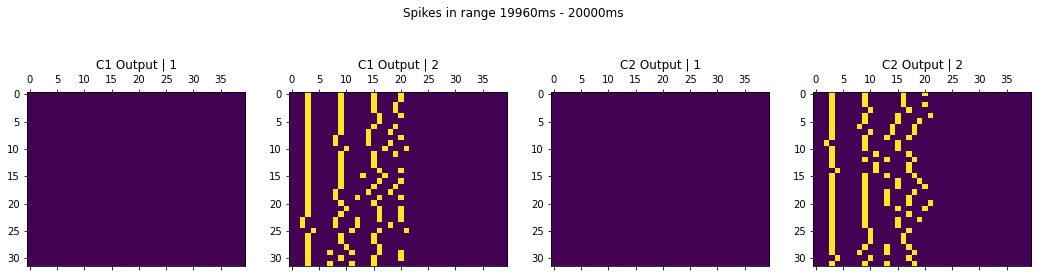

In [34]:
show_spikes(x, ["C1 Output | 1", "C1 Output | 2", "C2 Output | 1", "C2 Output | 2"], fig_size=(18,5))

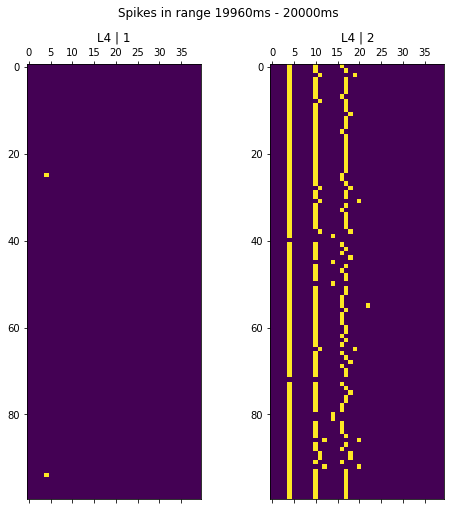

In [35]:
show_spikes(x, ["L4 | 1", "L4 | 2"], fig_size=(8,8))

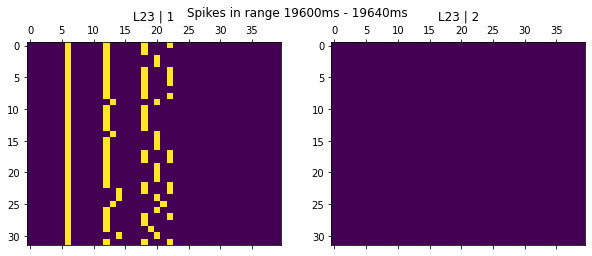

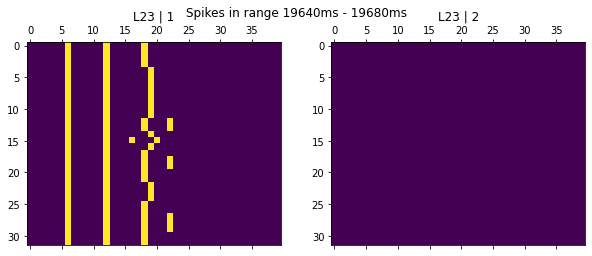

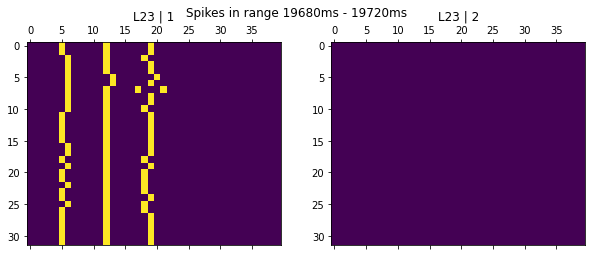

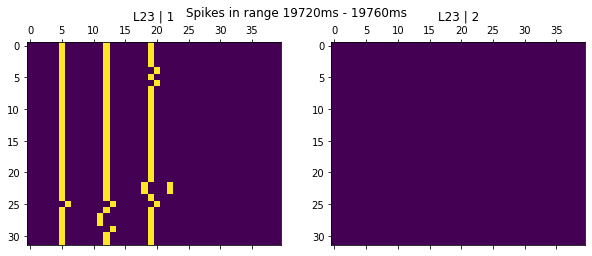

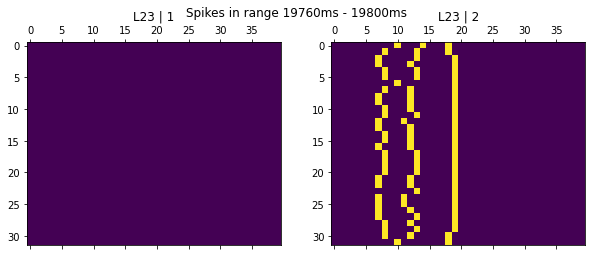

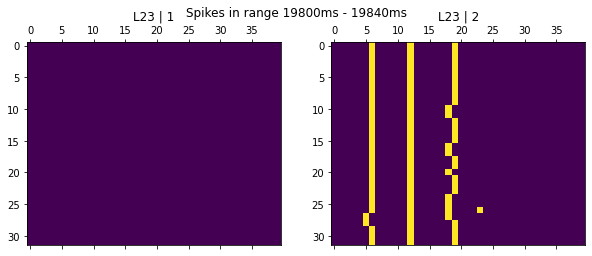

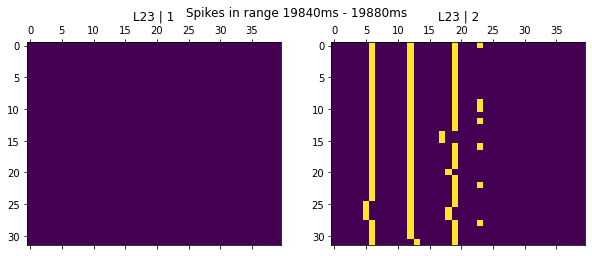

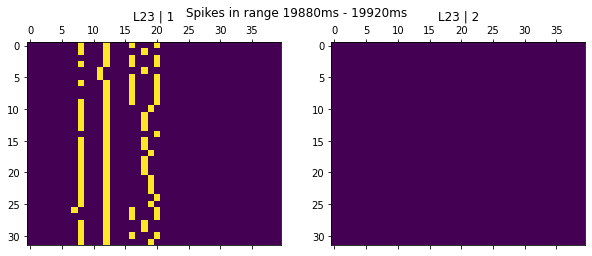

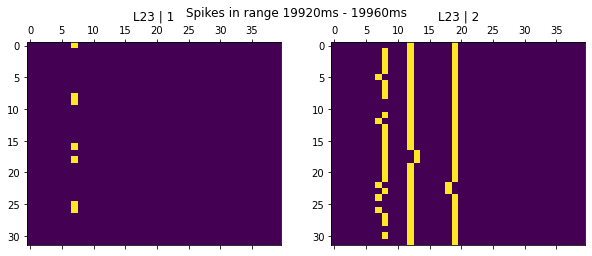

In [36]:
# print(session_class[x])
# plt.matshow(spikes["L23 | 1"][:, x * each_session:x * each_session + each_session])
# plt.matshow(spikes["L23 | 2"][:, x * each_session:x * each_session + each_session])
for x in range(490, 499):
    show_spikes(x, ["L23 | 1", "L23 | 2"], fig_size=(10,4))

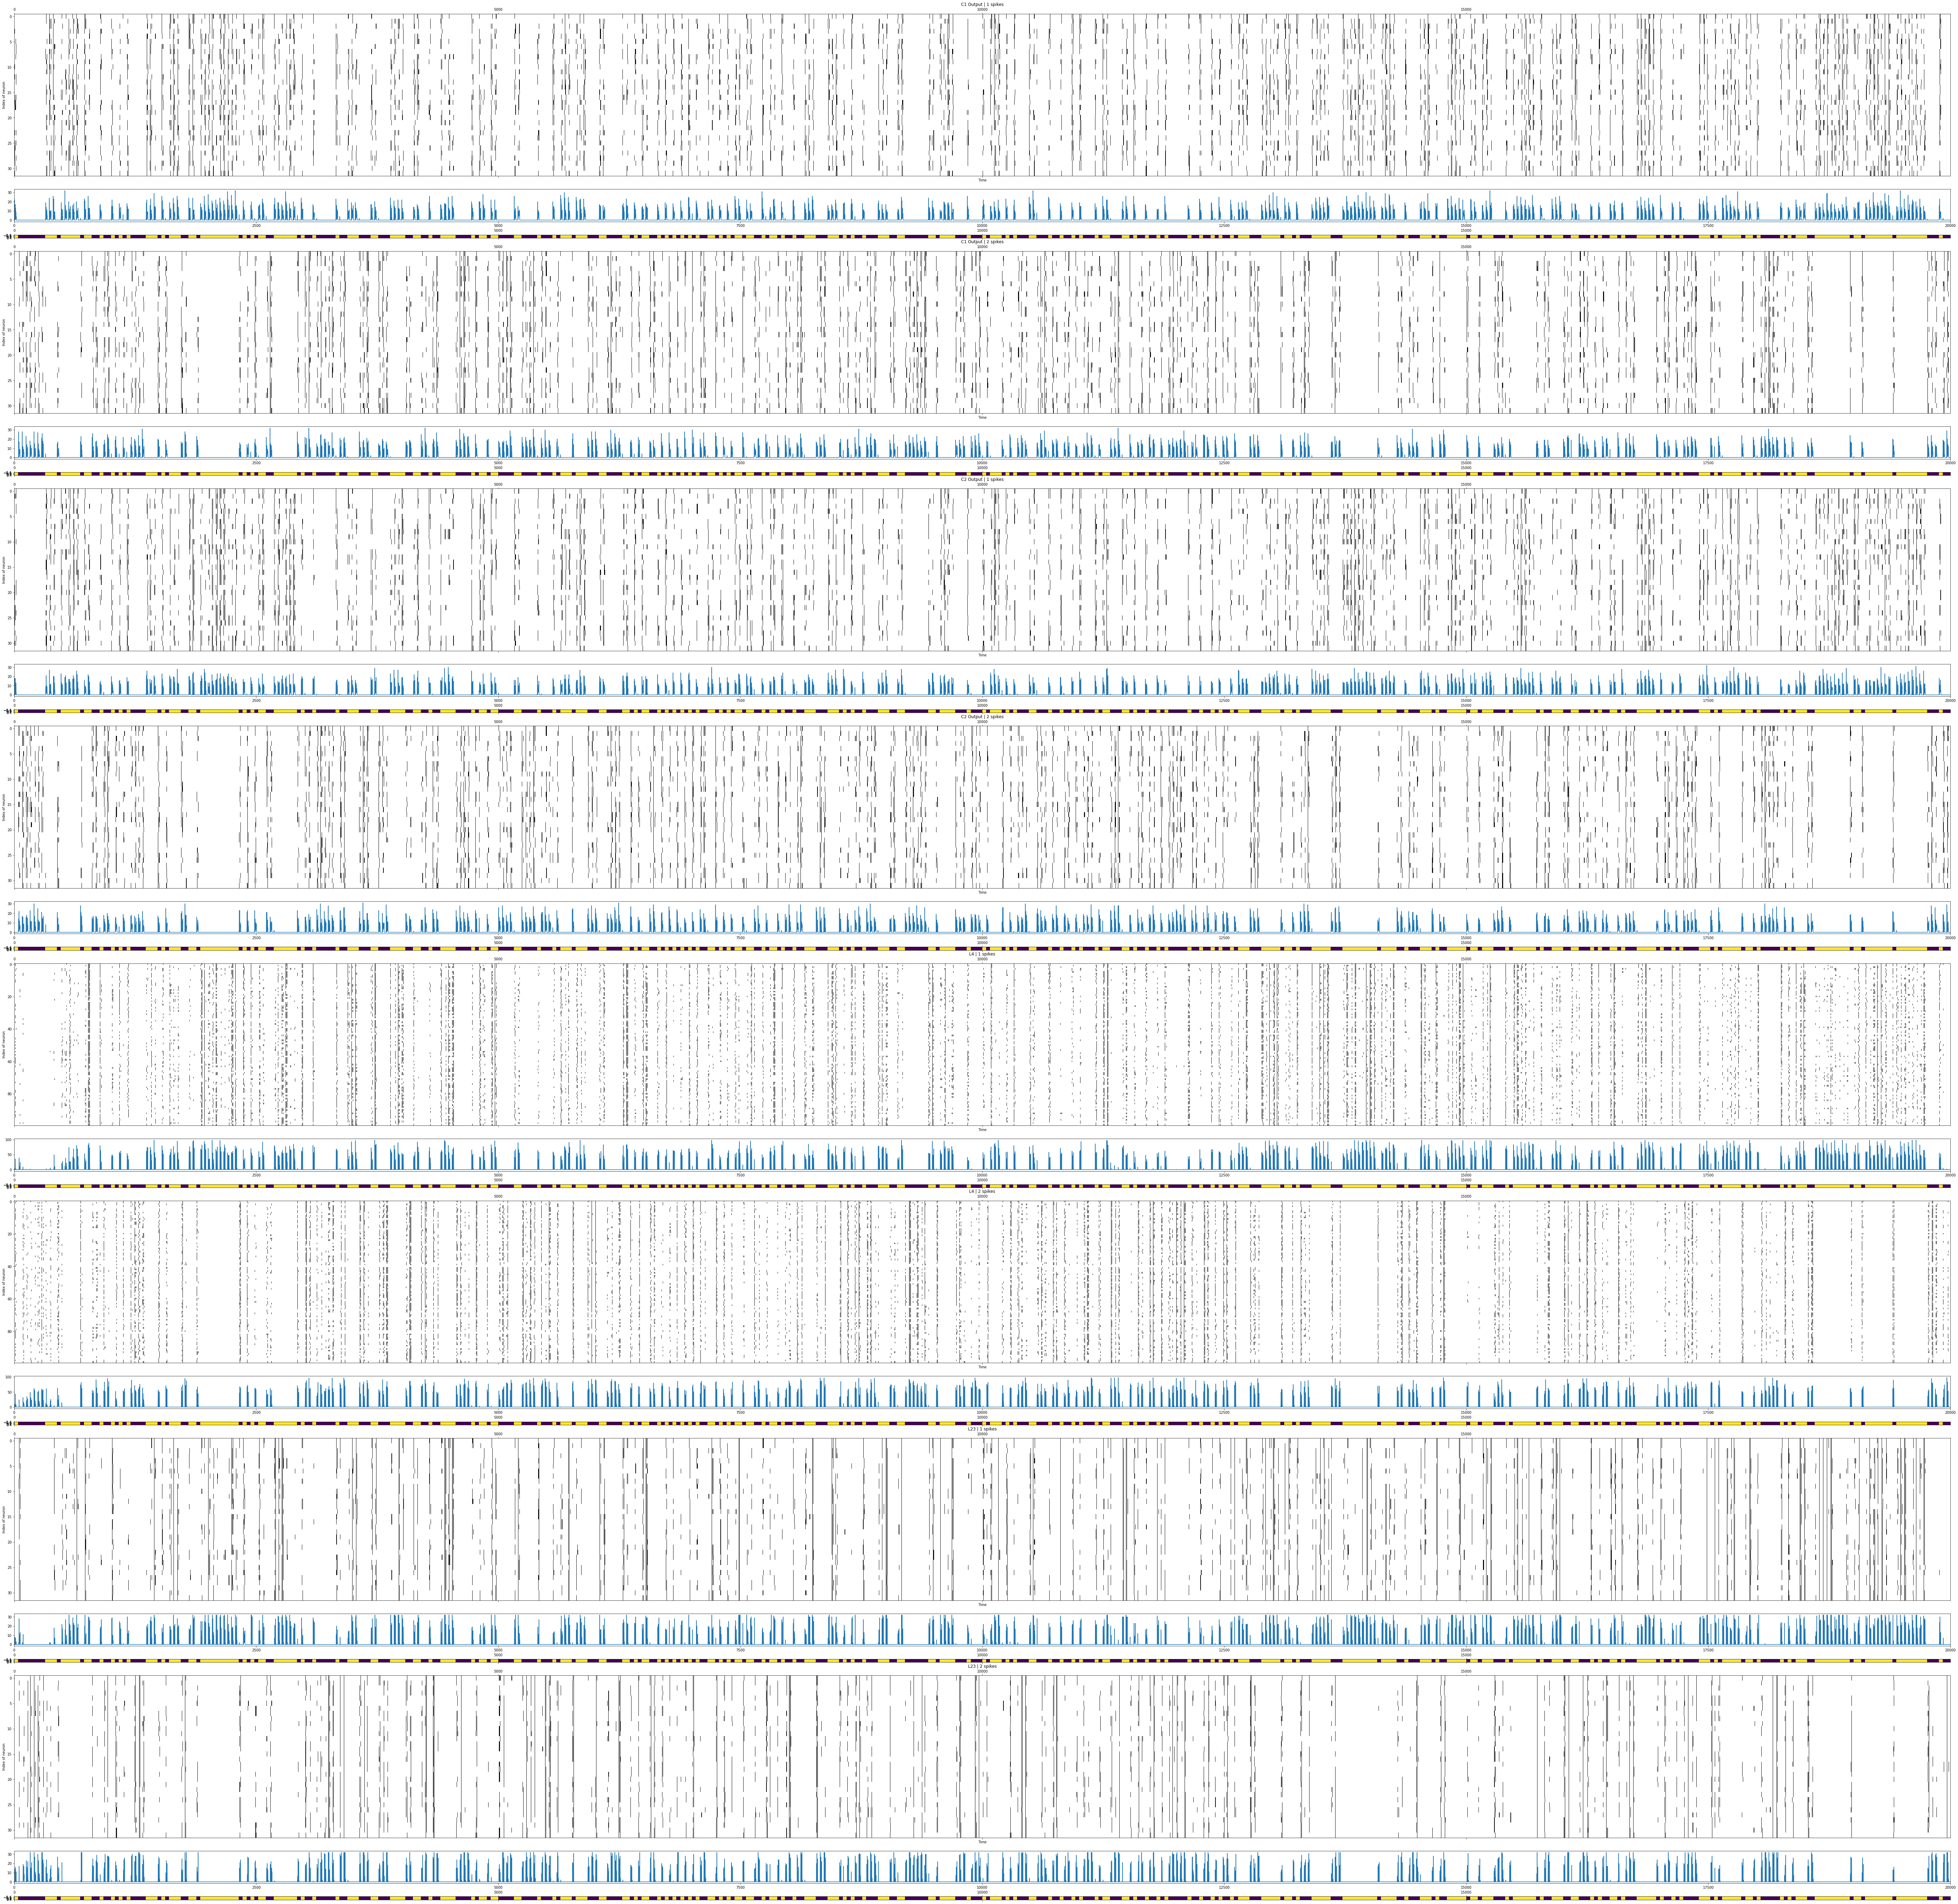

In [37]:
ver_num = len(spikes)
fig, axes = plt.subplots(ver_num * 3, 1, figsize=(100, 100), gridspec_kw={'height_ratios': [50, 10, 1] * ver_num})
# fig.suptitle(f"Spikes: t={start_time}-{end_time}")
for idx, layer in enumerate(spikes):
    indx = idx * 3
    axes[indx].matshow(spikes[layer], cmap='Greys')
    axes[indx].set_title('%s spikes' % layer)
    axes[indx].set_xlabel('Time')
    axes[indx].set_ylabel('Index of neuron')
    axes[indx].set_aspect('auto')
    
    activity = spikes[layer].sum(0)
    axes[indx + 1].plot(activity)
    axes[indx + 1].set_aspect('auto')
    axes[indx + 1].set_xlim([0, activity.shape[0]])
    
    axes[indx + 2].matshow(timestep_class[-time_show:].unsqueeze(1).T)
    axes[indx + 2].set_aspect('auto')